# Monkeypox Detection

* [Google Colab Notebook](https://colab.research.google.com/drive/1X_CC7FaJsyxIOkK-_tgastv71yBsh6w-?usp=sharing)
* [Dataset](https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset)


# Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load the data

If you use google colab for training, you can use kaggle datasets directly with the help of a token. [Reference](https://www.kaggle.com/general/74235)

In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                    title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
deepcontractor/mcdonalds-india-menu-nutrition-facts    McDonald's India : Menu Nutrition Dataset          5KB  2022-07-28 17:08:52           2725        121  0.9411765        
iamsouravbanerjee/house-rent-prediction-dataset        House Rent Prediction Dataset                     82KB  2022-08-20 13:49:03           2728        109  1.0              
arianazmoudeh/airbnbopendata                           Airbnb Open Data                                  10MB  2022-08-01 15:58:10           1846         65  0.9705882        
ericsims/world-cheese-awards-worlds-cheesiest-dataset  World Cheese Awards (World's Ch

In [3]:
!kaggle datasets download -d nafin59/monkeypox-skin-lesion-dataset

!unzip /content/monkeypox-skin-lesion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_06.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_07.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_08.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_09.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_10.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_11.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_12.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_01_13.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_02_00.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_02_01.jpg  
  inflating: Augmented Images/Augmented Images/Monkeypox_augmented/M40_02_02.jpg  
  inflating: Augmented Images/Augmen

In [4]:
IMAGE_DIR = "/content/Original Images/Original Images"

In [5]:
# Create a list of all the class names
import os

class_names = sorted(os.listdir(IMAGE_DIR))
class_names

['Monkey Pox', 'Others']

# Split into train, test and validation data (using [splitfolders](https://pypi.org/project/split-folders/))

In [6]:
!pip install split-folders

import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Splitting the data into 3 datasets:**
* 70% in training dataset
* 20% in validation dataset
* 10% in testing dataset

In [7]:
splitfolders.ratio(IMAGE_DIR, output="IMAGES", seed=42, ratio=(.7, .2, .1))

Copying files: 228 files [00:00, 9602.77 files/s]


In [8]:
# Defining the training, validation and testing directories
IMAGE_DIR = "/content/IMAGES/"

TRAIN_DIR = "/content/IMAGES/train/"
VAL_DIR = "/content/IMAGES/val/"
TEST_DIR = "/content/IMAGES/test/"

# View images in training dataset

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [10]:
def view_random_images(dirpath, class_names=class_names):
  """
  A utility function to view random images and their labels from the specified directory
  """
  plt.figure(figsize=(20, 14))
  for i in range(1, 6):
    class_name = random.choice(class_names)

    img = mpimg.imread(dirpath+class_name+"/"+random.choice(os.listdir(dirpath+class_name)))
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)
    

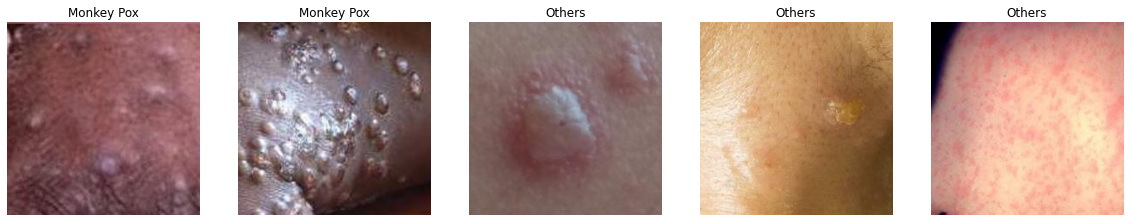

In [11]:
view_random_images(TRAIN_DIR, class_names=class_names)

# Create ImageDataGenerators

Create ImageDataGenerators to Rescale our images between 0 and 1 i.e., **Normalizing** the images. Also performing data augmentation.


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255., 
                                 rotation_range=0.2, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 zoom_range=0.2, 
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255., 
                                  rotation_range=0.2, 
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  zoom_range=0.2, 
                                  horizontal_flip=True)

Creating training, validation and testing data

In [13]:
train_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary")

val_data = val_datagen.flow_from_directory(VAL_DIR,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode="binary")

test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="binary")

Found 159 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


# Creating a basic model

In [15]:
import tensorflow as tf

In [ ]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 150528)            0         
                                                                 
 dense_16 (Dense)            (None, 4)                 602116    
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
history_1 = model_1.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/20
5/5 [==============================] - 3s 551ms/step - loss: 4.5895 - accuracy: 0.5409 - val_loss: 2.6270 - val_accuracy: 0.5556
Epoch 2/20
5/5 [==============================] - 2s 446ms/step - loss: 1.0250 - accuracy: 0.4906 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 3/20
5/5 [==============================] - 2s 437ms/step - loss: 0.6935 - accuracy: 0.4465 - val_loss: 0.6935 - val_accuracy: 0.4444
Epoch 4/20
5/5 [==============================] - 2s 435ms/step - loss: 0.6935 - accuracy: 0.4465 - val_loss: 0.7984 - val_accuracy: 0.4222
Epoch 5/20
5/5 [==============================] - 2s 438ms/step - loss: 0.7173 - accuracy: 0.4403 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 6/20
5/5 [==============================] - 2s 446ms/step - loss: 0.6934 - accuracy: 0.4465 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 7/20
5/5 [==============================] - 2s 444ms/step - loss: 0.6933 - accuracy: 0.4465 - val_loss: 0.6933 - val_accuracy: 0.4444
Epoch 8/20
5/5 [====

## Plot the curves

In [14]:
def plot_curves(history):
  """
  A utility function that inputs a keras History object and plot the loss and accuracy (both training and validation) of the model 
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(20, 7))
  plt.rcParams['font.size'] = '16'

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


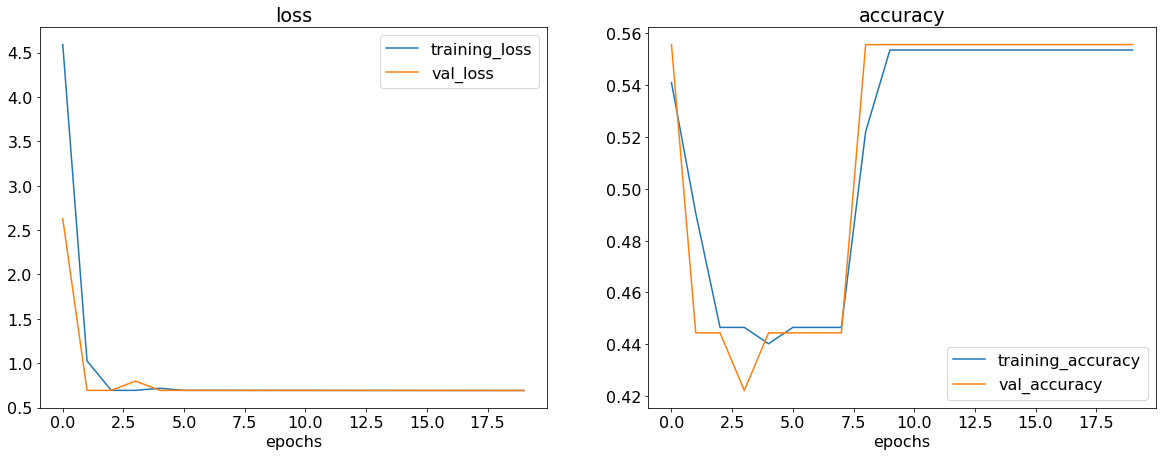

In [ ]:
plot_curves(history_1)

## Get predictions on testing data

In [ ]:
model_1.evaluate(test_data)

1/1 [==============================] - 0s 271ms/step - loss: 0.6922 - accuracy: 0.5417


[0.6922023892402649, 0.5416666865348816]

## Save the model

In [ ]:
model_1.save("/content/gdrive/MyDrive/ML Notebooks/SSOC/MonkeyPox Detection models/model_1.h5")

# Improving the model (Adding Convolutional Layers)

In [ ]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_22 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_11 (Flatten)        (None, 475240)            0         
                                                                 
 dense_19 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
history_2 = model_2.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/20
5/5 [==============================] - 3s 576ms/step - loss: 1.8203 - accuracy: 0.4843 - val_loss: 0.9310 - val_accuracy: 0.4444
Epoch 2/20
5/5 [==============================] - 2s 467ms/step - loss: 0.8337 - accuracy: 0.4780 - val_loss: 0.8990 - val_accuracy: 0.5556
Epoch 3/20
5/5 [==============================] - 2s 474ms/step - loss: 0.7755 - accuracy: 0.5220 - val_loss: 0.6941 - val_accuracy: 0.6000
Epoch 4/20
5/5 [==============================] - 2s 476ms/step - loss: 0.6911 - accuracy: 0.5597 - val_loss: 0.7303 - val_accuracy: 0.4444
Epoch 5/20
5/5 [==============================] - 2s 471ms/step - loss: 0.6857 - accuracy: 0.5597 - val_loss: 0.6620 - val_accuracy: 0.6222
Epoch 6/20
5/5 [==============================] - 2s 466ms/step - loss: 0.6681 - accuracy: 0.5786 - val_loss: 0.6409 - val_accuracy: 0.6222
Epoch 7/20
5/5 [==============================] - 2s 469ms/step - loss: 0.6588 - accuracy: 0.5912 - val_loss: 0.6273 - val_accuracy: 0.6000
Epoch 8/20
5/5 [====

## Plot the curves

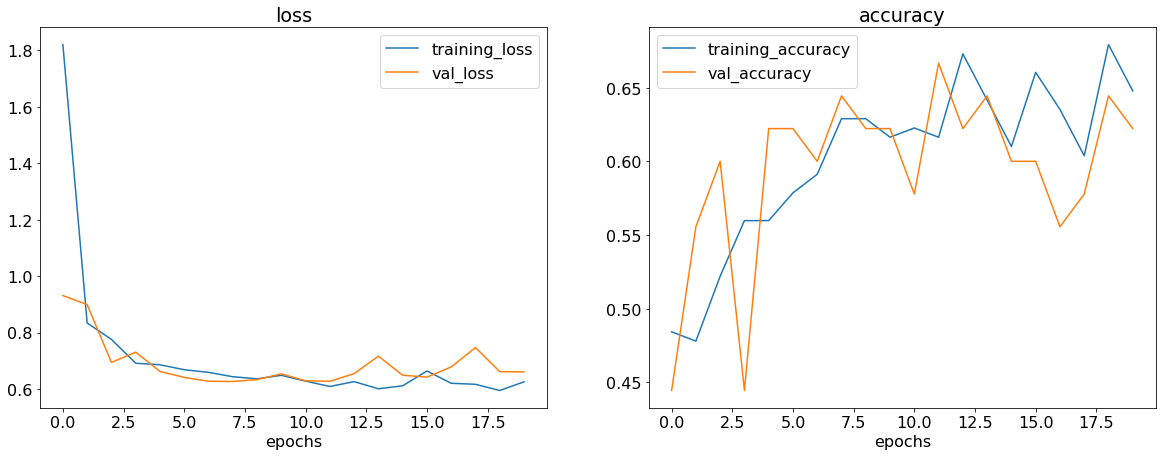

In [ ]:
plot_curves(history_2)

## Get predictions on testing data

In [ ]:
model_2.evaluate(test_data)

1/1 [==============================] - 0s 285ms/step - loss: 0.9307 - accuracy: 0.4583


[0.9307023882865906, 0.4583333432674408]

## Save the model

In [ ]:
model_2.save("/content/gdrive/MyDrive/ML Notebooks/SSOC/MonkeyPox Detection models/model_2.h5")

# Improving the model further (Adding MaxPooling Layers)

In [ ]:
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),                                   
  tf.keras.layers.MaxPool2D(pool_size=2),

  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),

  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 10)     

## Train the model

In [ ]:
history_3 = model_3.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/20
5/5 [==============================] - 3s 559ms/step - loss: 0.6927 - accuracy: 0.5535 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 2/20
5/5 [==============================] - 2s 454ms/step - loss: 0.7110 - accuracy: 0.4906 - val_loss: 0.6765 - val_accuracy: 0.5778
Epoch 3/20
5/5 [==============================] - 2s 458ms/step - loss: 0.6769 - accuracy: 0.5535 - val_loss: 0.6677 - val_accuracy: 0.5556
Epoch 4/20
5/5 [==============================] - 2s 457ms/step - loss: 0.6851 - accuracy: 0.5535 - val_loss: 0.6559 - val_accuracy: 0.5778
Epoch 5/20
5/5 [==============================] - 2s 449ms/step - loss: 0.6704 - accuracy: 0.6101 - val_loss: 0.6577 - val_accuracy: 0.6667
Epoch 6/20
5/5 [==============================] - 2s 447ms/step - loss: 0.6649 - accuracy: 0.6478 - val_loss: 0.6461 - val_accuracy: 0.7111
Epoch 7/20
5/5 [==============================] - 2s 448ms/step - loss: 0.6515 - accuracy: 0.6541 - val_loss: 0.6249 - val_accuracy: 0.7111
Epoch 8/20
5/5 [====

## Plot the curves

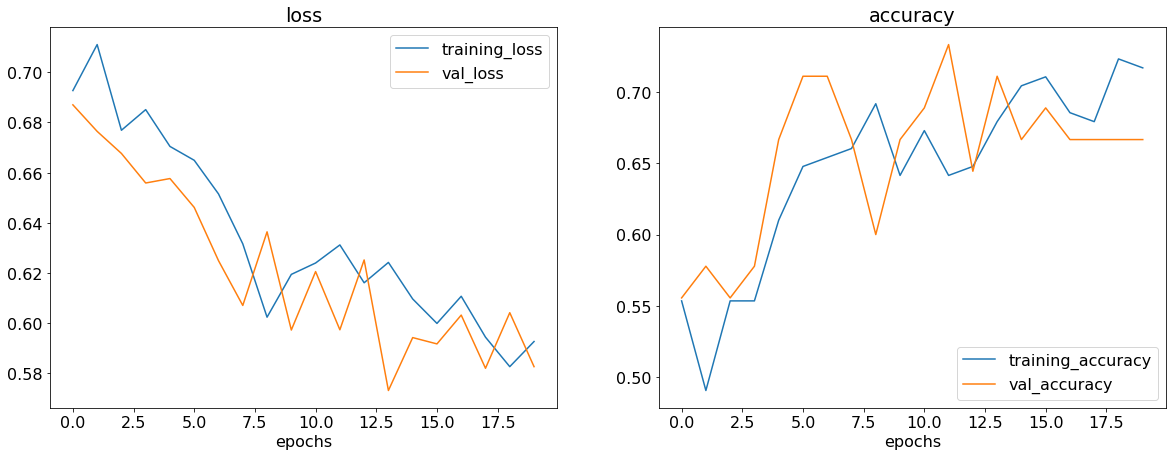

In [ ]:
plot_curves(history_3)

## Get predictions on testing data

In [ ]:
model_3.evaluate(test_data)

1/1 [==============================] - 0s 272ms/step - loss: 0.7153 - accuracy: 0.5000


[0.7153369784355164, 0.5]

## Save the model

In [ ]:
model_3.save("/content/gdrive/MyDrive/ML Notebooks/SSOC/MonkeyPox Detection models/model_3.h5")

# Transfer Learning

In [19]:
import tensorflow_hub as hub

In [20]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [26]:
model_4 = tf.keras.models.Sequential([
    hub.KerasLayer(resnet_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224)+(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')                                  
    ])

model_4.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [27]:
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
history_4 = model_4.fit(train_data,
            epochs=20,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/20
5/5 [==============================] - 21s 1s/step - loss: 0.8913 - accuracy: 0.4340 - val_loss: 0.6437 - val_accuracy: 0.6444
Epoch 2/20
5/5 [==============================] - 2s 507ms/step - loss: 0.6868 - accuracy: 0.5975 - val_loss: 0.6127 - val_accuracy: 0.6444
Epoch 3/20
5/5 [==============================] - 2s 514ms/step - loss: 0.5797 - accuracy: 0.7044 - val_loss: 0.5731 - val_accuracy: 0.7333
Epoch 4/20
5/5 [==============================] - 2s 497ms/step - loss: 0.5440 - accuracy: 0.7296 - val_loss: 0.5880 - val_accuracy: 0.6889
Epoch 5/20
5/5 [==============================] - 2s 506ms/step - loss: 0.4705 - accuracy: 0.7610 - val_loss: 0.5599 - val_accuracy: 0.7111
Epoch 6/20
5/5 [==============================] - 3s 620ms/step - loss: 0.4486 - accuracy: 0.8113 - val_loss: 0.5375 - val_accuracy: 0.8000
Epoch 7/20
5/5 [==============================] - 2s 509ms/step - loss: 0.4342 - accuracy: 0.7987 - val_loss: 0.4982 - val_accuracy: 0.8000
Epoch 8/20
5/5 [======

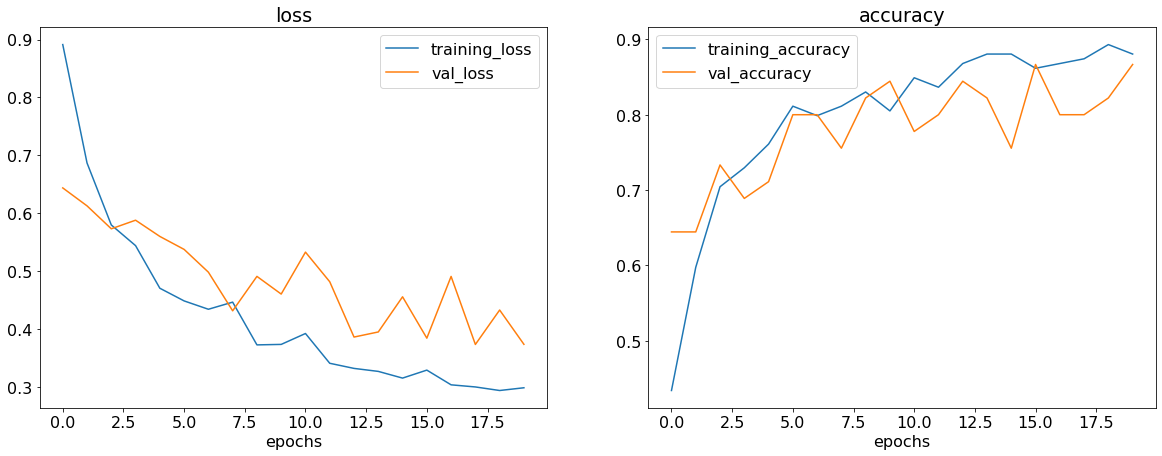

In [29]:
plot_curves(history_4)

In [30]:
model_4.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.3988 - accuracy: 0.8750


[0.39880892634391785, 0.875]

In [31]:
model_4.save("/content/gdrive/MyDrive/ML Notebooks/SSOC/MonkeyPox Detection models/model_4.h5")

# Training the transfer learning model for epochs

In [38]:
model_5 = tf.keras.models.Sequential([
    hub.KerasLayer(resnet_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224)+(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')                                  
    ])

model_5.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [39]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [44]:
history_5 = model_5.fit(train_data,
            epochs=100,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/100
5/5 [==============================] - 3s 599ms/step - loss: 0.1635 - accuracy: 0.9748 - val_loss: 0.4221 - val_accuracy: 0.7556
Epoch 2/100
5/5 [==============================] - 2s 509ms/step - loss: 0.1665 - accuracy: 0.9560 - val_loss: 0.4946 - val_accuracy: 0.8444
Epoch 3/100
5/5 [==============================] - 2s 515ms/step - loss: 0.1710 - accuracy: 0.9560 - val_loss: 0.3511 - val_accuracy: 0.8444
Epoch 4/100
5/5 [==============================] - 2s 502ms/step - loss: 0.1637 - accuracy: 0.9560 - val_loss: 0.3903 - val_accuracy: 0.8222
Epoch 5/100
5/5 [==============================] - 2s 504ms/step - loss: 0.1651 - accuracy: 0.9686 - val_loss: 0.4123 - val_accuracy: 0.8222
Epoch 6/100
5/5 [==============================] - 2s 507ms/step - loss: 0.1481 - accuracy: 0.9434 - val_loss: 0.4482 - val_accuracy: 0.7778
Epoch 7/100
5/5 [==============================] - 2s 520ms/step - loss: 0.1547 - accuracy: 0.9623 - val_loss: 0.4978 - val_accuracy: 0.7778
Epoch 8/100
5

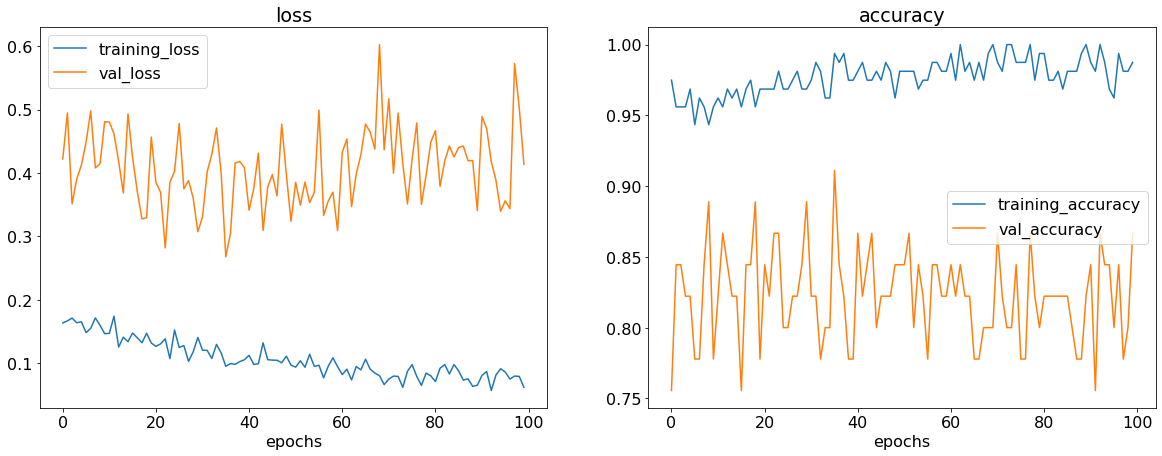

In [45]:
plot_curves(history_5)

In [46]:
model_5.evaluate(test_data)

1/1 [==============================] - 0s 362ms/step - loss: 0.2618 - accuracy: 0.9167


[0.2618398368358612, 0.9166666865348816]

In [47]:
model_5.save("/content/gdrive/MyDrive/ML Notebooks/SSOC/MonkeyPox Detection models/model_5.h5")

# Predict a random image from testing dataset

In [48]:
def pred_and_show(model, img_path, actual_class, class_names=class_names):
  """
  An utility function that uses the input model and makes prediction
  """
  # Read in the image
  img = tf.io.read_file(img_path)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [224, 224])
  # Rescale the image (get all values betwen 0 & 1)
  img = img/255.

  pred = model.predict(tf.expand_dims(img, 0))

  if len(class_names) > 2:
    class_name = class_names[int(tf.argmax(pred[0]))]
  else:
    class_name = class_names[int(tf.round(pred[0]))]

  plt.imshow(img)
  plt.title(f"Actual: {actual_class}\nPredicted: {class_name}")
  plt.axis(False)

In [49]:
def pred_random_image(model, dir_path=TEST_DIR, class_names=class_names):
  """
  This function selects a random image from the specified directory and then predicts the possible class by calling the pred_and_show function
  """
  random_class = random.choice(class_names)

  img_path = dir_path + random_class + "/" + random.choice(os.listdir(dir_path + random_class))
  
  pred_and_show(model, img_path, random_class, class_names)

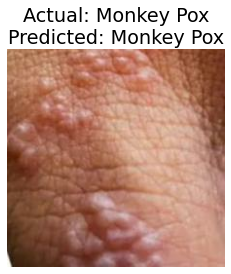

In [54]:
pred_random_image(model_5, TEST_DIR, class_names)